In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [5]:
df.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [6]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [7]:
columns_to_fill = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df[columns_to_fill] = df[columns_to_fill].fillna(0)

In [8]:
df = df.drop(['Name', 'PassengerId'], axis=1)

In [9]:
df = df.dropna(subset=['CryoSleep', 'Age', 'Cabin', 'VIP'])

In [10]:
df.loc[:, 'Destination'] = df['Destination'].fillna(df['Destination'].mode()[0])
df.loc[:, 'HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].mode()[0])

In [11]:
df[['Cabin1', 'Cabin2', 'Cabin3']] = df['Cabin'].str.split('/', expand=True)
df = df.drop(['Cabin'], axis=1)

In [12]:
df['Cabin2'] = df['Cabin2'].astype('int64')
df['Transported'] = df['Transported'].astype('int64')

In [13]:
X = df.drop(['Transported'], axis=1)
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df[categorical_cols] = ordinal_encoder.fit_transform(df[categorical_cols].astype(str))

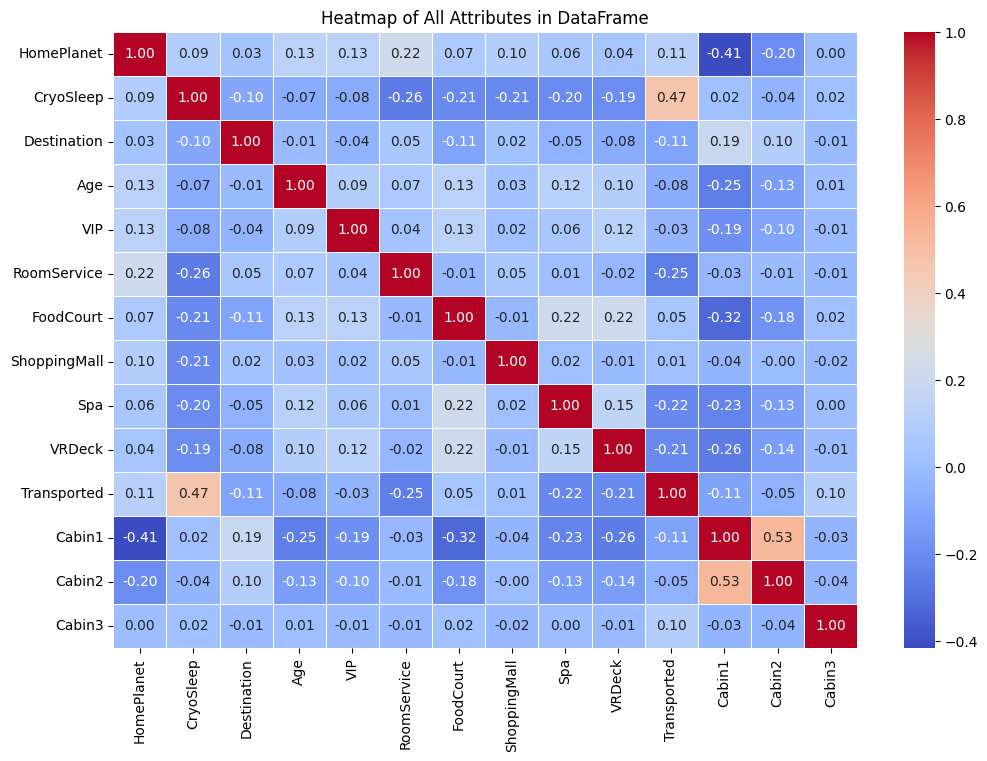

In [14]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap of All Attributes in DataFrame")
plt.show()

In [15]:
X = df.drop(['Transported'], axis=1)
y = df['Transported']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [16]:
model = CatBoostClassifier(learning_rate=0.1, random_seed=42, verbose=0)
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'iterations': [100, 200]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=0)

best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters: {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}
Best CV Accuracy: 0.8115


In [17]:
test[columns_to_fill] = test[columns_to_fill].fillna(0)
test = test.drop(['PassengerId', 'Name'], axis=1)
test.loc[:, 'Destination'] = test['Destination'].fillna(test['Destination'].mode()[0])
test.loc[:, 'HomePlanet'] = test['HomePlanet'].fillna(test['HomePlanet'].mode()[0])
test.loc[:, 'Cabin'] = test['Cabin'].fillna(test['Cabin'].mode()[0])
test.loc[:, 'CryoSleep'] = test['CryoSleep'].fillna(test['CryoSleep'].mode()[0])
test.loc[:, 'VIP'] = test['VIP'].fillna(test['VIP'].mode()[0])
test.loc[:, 'Age'] = test['Age'].fillna(test['Age'].mode()[0])
test[['Cabin1', 'Cabin2', 'Cabin3']] = test['Cabin'].str.split('/', expand=True)
test['Cabin2'] = test['Cabin2'].astype('int64')
test = test.drop(['Cabin'], axis=1)
test[numerical_cols] = scaler.transform(test[numerical_cols])
test[categorical_cols] = ordinal_encoder.transform(test[categorical_cols].astype(str))

In [18]:
y_pred = best_model.predict(test)

In [19]:
sub['Transported'] = y_pred
sub=sub.replace({0:False, 1:True})

In [20]:
sub.to_csv('submission.csv', index=False)